In [1]:
!pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms yfinance xgboost seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 7.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from qiskit_aer.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals


from IPython.display import clear_output

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

SEED = 42
np.random.seed(SEED)
algorithm_globals.random_seed = SEED


In [4]:
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-01-01")

data["Return"] = data["Close"].pct_change()
data["Volatility"] = data["Return"].rolling(5).std()
data["MA5"] = data["Close"].rolling(5).mean()
data["MA10"] = data["Close"].rolling(10).mean()

data["Target"] = (data["Return"].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

features = ["Return", "Volatility", "MA5", "MA10"]
X = data[features].values
y = data["Target"].values

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[*********************100%***********************]  1 of 1 completed


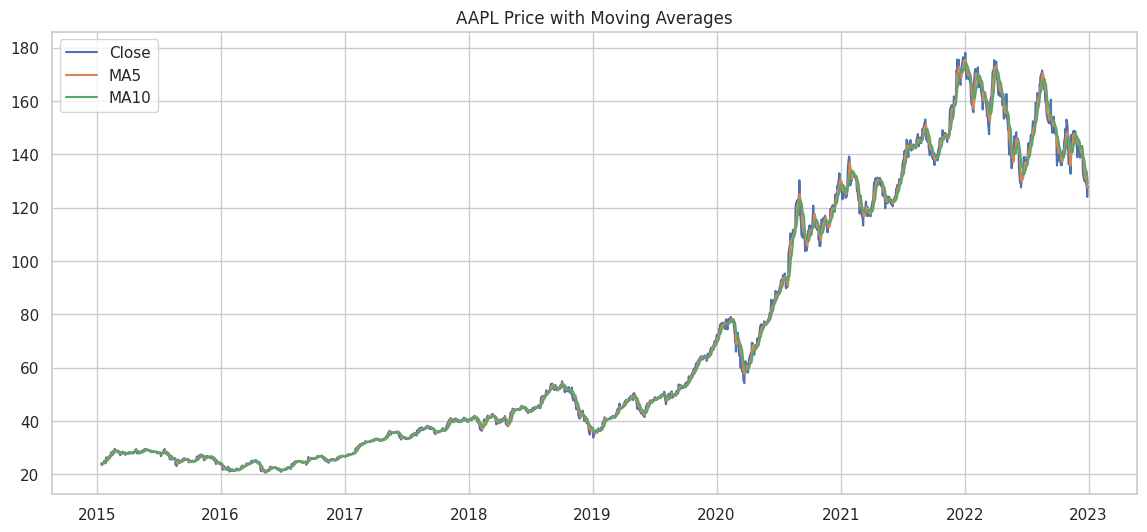

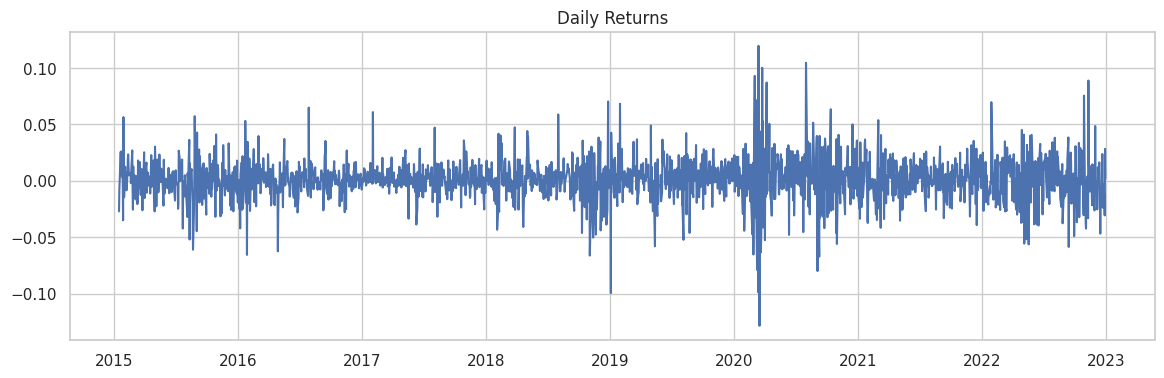

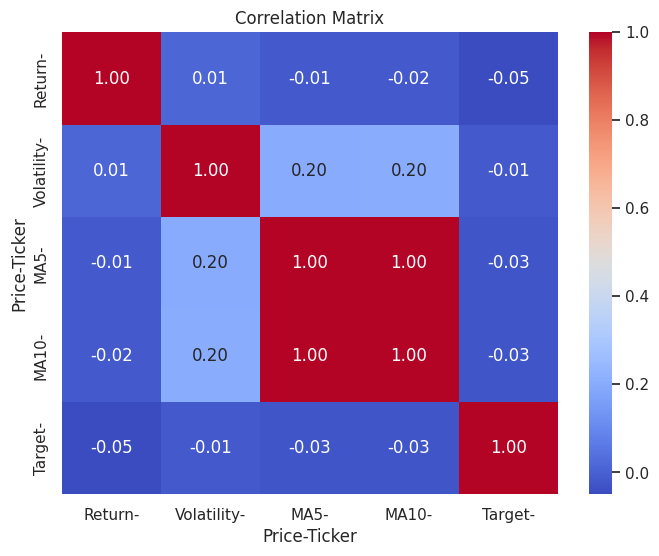

In [5]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data["Close"], label="Close")
plt.plot(data.index, data["MA5"], label="MA5")
plt.plot(data.index, data["MA10"], label="MA10")
plt.title(f"{ticker} Price with Moving Averages")
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(data.index, data["Return"])
plt.title("Daily Returns")
plt.show()

plt.figure(figsize=(8,6))
corr = data[features + ["Target"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [6]:
baseline_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print("Baseline accuracy:", round(baseline_acc, 4))

logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=SEED)
xgb = XGBClassifier(random_state=SEED)

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

models = {
    "LogReg": logreg,
    "RandomForest": rf,
    "XGBoost": xgb
}

results = {}

for name, model in models.items():
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {round(acc,4)}")
    print(f"{name} F1: {round(f1,4)}\n")

Baseline accuracy: 0.5087
LogReg Accuracy: 0.4838
LogReg F1: 0.5369

RandomForest Accuracy: 0.4938
RandomForest F1: 0.2039

XGBoost Accuracy: 0.4838
XGBoost F1: 0.4234



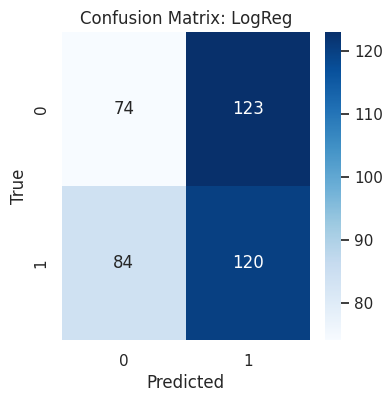

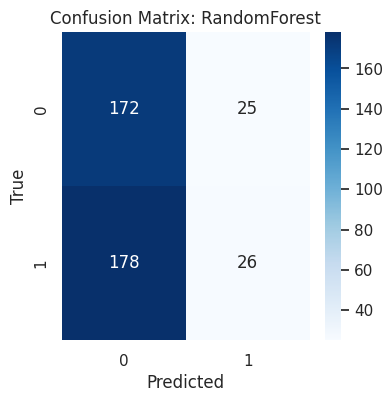

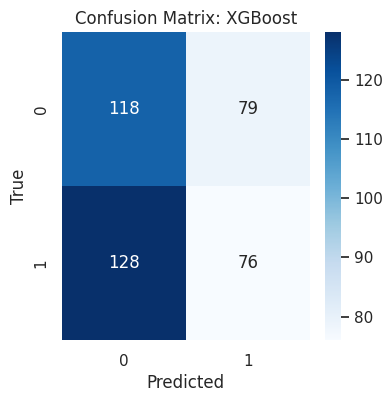

In [7]:
def plot_confusion(model, name):
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

for name, model in models.items():
    plot_confusion(model, name)

In [10]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
ansatz = RealAmplitudes(4, reps=2)

feature_map.decompose().draw("mpl")
ansatz.decompose().draw("mpl")

objective_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_vals.append(obj_func_eval)
    plt.figure(figsize=(10,5))
    plt.title("Objective Function During VQC Training")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(objective_vals)
    plt.show()

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph
)

print("Training VQC...")
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed,2)} sec")

vqc_acc = vqc.score(X_test, y_test)
results["VQC"] = vqc_acc

print("VQC Accuracy:", round(vqc_acc,4))


Training VQC...
Training time: 936.93 sec
VQC Accuracy: 0.5212


In [17]:
feature_map.decompose().draw("text")
ansatz.decompose().draw("text")


┌──────────┐                             ┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├──────────────────────■──────┤ Ry(θ[4]) ├─────────────»
     ├──────────┤                    ┌─┴─┐    ├──────────┤             »
q_1: ┤ Ry(θ[1]) ├──────────■─────────┤ X ├────┤ Ry(θ[5]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├──■─────┤ X ├────┤ Ry(θ[6]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[7]) ├───────────────┤ X ├────┤ Ry(θ[11]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                  ┌──────────┐
«q_0: ──────■──────┤ Ry(θ[8]) ├
«         ┌─┴─┐    ├──────────┤
«q_1: ────┤ X ├────┤ Ry(θ[9]) ├
«     ┌───┴───┴───┐└──────────┘
«q_2: ┤ Ry(θ[10]) ├────────────
«     └───────────┘            
«q_3: ─────────────────────────
«

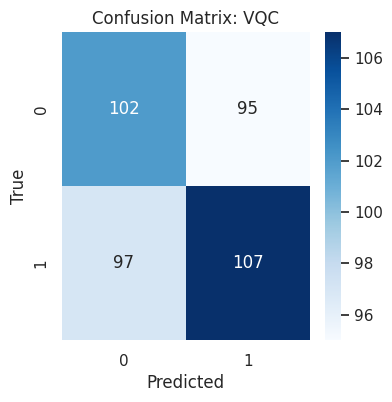

In [11]:
plot_confusion(vqc, "VQC")

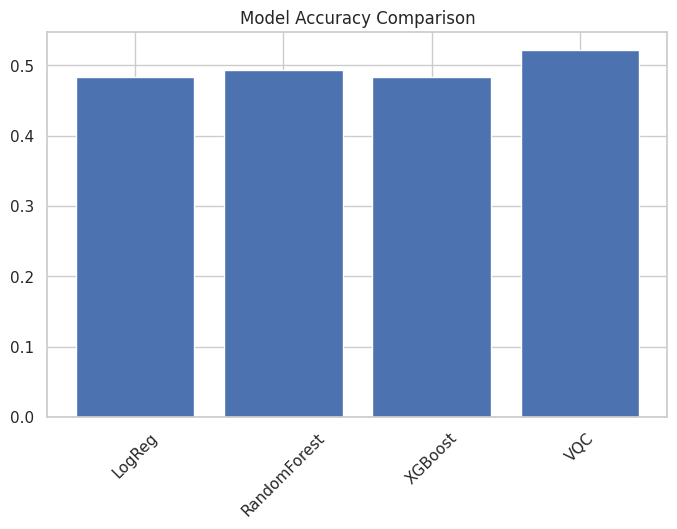

In [12]:
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [18]:
from qiskit.circuit.library import PauliFeatureMap
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import ttest_ind

feature_maps = [
    ZZFeatureMap(4, reps=1),
    ZZFeatureMap(4, reps=2),
    PauliFeatureMap(4, reps=1, paulis=["Z", "ZZ"])
]

ensemble_models = []
ensemble_preds_train = []
ensemble_preds_test = []

for i, fm in enumerate(feature_maps):
    print(f"\nTraining VQC #{i+1}")
    model = VQC(
        feature_map=fm,
        ansatz=ansatz,
        optimizer=COBYLA(maxiter=100)
    )
    model.fit(X_train, y_train)
    ensemble_models.append(model)

    ensemble_preds_train.append(model.predict(X_train))
    ensemble_preds_test.append(model.predict(X_test))

ensemble_preds_train = np.column_stack(ensemble_preds_train)
ensemble_preds_test = np.column_stack(ensemble_preds_test)

meta_model = LogisticRegression()
meta_model.fit(ensemble_preds_train, y_train)

meta_preds = meta_model.predict(ensemble_preds_test)
meta_acc = accuracy_score(y_test, meta_preds)

results["Quantum_Ensemble"] = meta_acc

print("\nStacking Accuracy:", round(meta_acc,4))


Training VQC #1



Training VQC #2



Training VQC #3

Stacking Accuracy: 0.5087


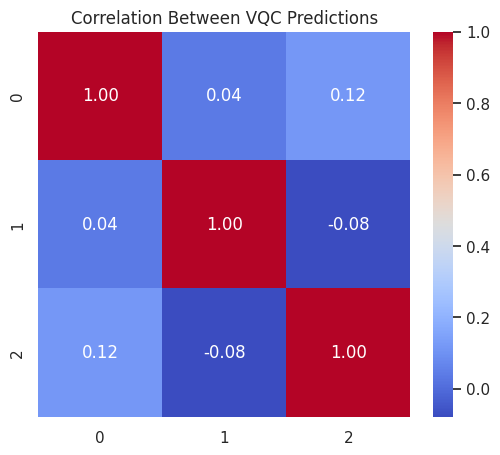

In [19]:
corr_matrix = np.corrcoef(ensemble_preds_test.T)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between VQC Predictions")
plt.show()


In [20]:
runs = 5
vqc_scores = []
ensemble_scores = []

for run in range(runs):
    np.random.seed(SEED + run)
    algorithm_globals.random_seed = SEED + run

    model = VQC(
        feature_map=ZZFeatureMap(4, reps=1),
        ansatz=ansatz,
        optimizer=COBYLA(maxiter=50)
    )
    model.fit(X_train, y_train)
    vqc_scores.append(model.score(X_test, y_test))

    meta_model.fit(ensemble_preds_train, y_train)
    ensemble_scores.append(meta_model.score(ensemble_preds_test, y_test))

print("VQC mean:", np.mean(vqc_scores), "std:", np.std(vqc_scores))
print("Ensemble mean:", np.mean(ensemble_scores), "std:", np.std(ensemble_scores))

t_stat, p_value = ttest_ind(vqc_scores, ensemble_scores)

print("t-stat:", round(t_stat,4))
print("p-value:", round(p_value,4))



=== STATISTICAL EVALUATION ===


VQC mean: 0.49875311720698257 std: 0.013005890085192328
Ensemble mean: 0.5087281795511222 std: 0.0
t-stat: -1.5339
p-value: 0.1636


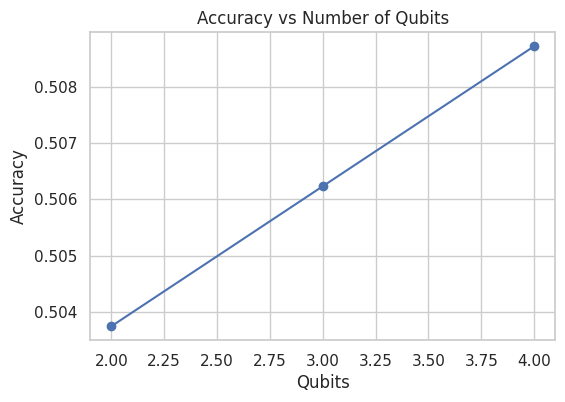

In [21]:
qubit_range = [2,3,4]
qubit_scores = []

for q in qubit_range:
    fm = ZZFeatureMap(q, reps=1)
    an = RealAmplitudes(q, reps=1)

    X_train_q = X_train[:, :q]
    X_test_q = X_test[:, :q]

    model = VQC(
        feature_map=fm,
        ansatz=an,
        optimizer=COBYLA(maxiter=50)
    )

    model.fit(X_train_q, y_train)
    score = model.score(X_test_q, y_test)
    qubit_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(qubit_range, qubit_scores, marker='o')
plt.title("Accuracy vs Number of Qubits")
plt.xlabel("Qubits")
plt.ylabel("Accuracy")
plt.show()


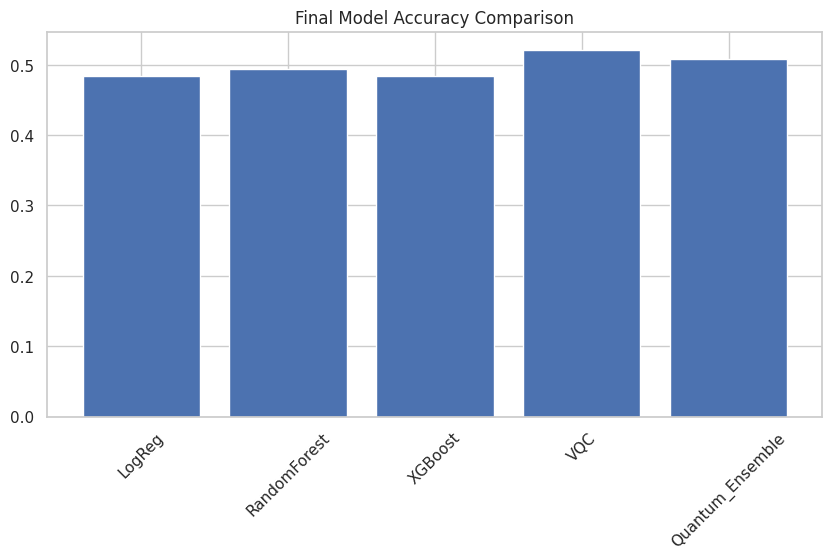

In [22]:
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values())
plt.title("Final Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()
